In [130]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import subprocess
import json
import os
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, auc, roc_curve
from sklearn.externals import joblib
from plotting import plot_confusion_matrix, plot_roc, plot_scores, plot_precision_recall, plot_feature_importance, plot_information_gain
from preprocessing import VandalismEncoder, RevisionGrouper, FeatureSelector
import warnings
warnings.filterwarnings(action='once')

In [131]:
# Import dataset
df = pd.read_csv('./data/features-total-4a115a8.csv', index_col='revision_id')
tag_df = pd.read_csv('./data/tag.csv', index_col='id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,sizeRatio,LZWCompressionRate,KLDOfCharDistribution,commentLength,userCommentLength,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.0,...,11910.000000,0.513889,1024.000000,34.0,34.0,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,0.833333,0.857143,0.5,...,0.003832,0.308994,4.126739,14.0,14.0,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.000000,0.000000,0.0,...,0.003622,0.434896,85.525822,67.0,0.0,0.0,0.0,2.0,0.0,12
539338621,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.000000,0.000000,0.0,...,-0.000196,0.353894,1.286642,152.0,0.0,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,23.0,2.0,2.0,0.0,-1.000000,-1.000000,-1.0,...,0.000048,0.428264,342.595182,10.0,10.0,0.0,0.0,0.0,0.0,12


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


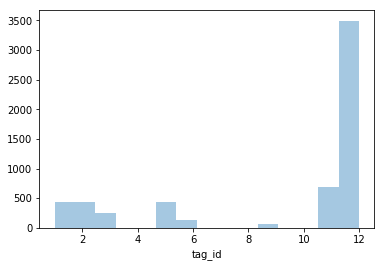

In [132]:
# Tag distribution
sns.distplot(df['tag_id'], kde=False)
plt.show()

In [133]:
BASELINE_FEATURE_COLUMNS = [
    # Context
    'isContributorAnonymous',
    'commentLength',
    'sizeChange',
    'timeSinceLastArticleEdit',
    'timeOfDay',
    'dayOfWeek',
    'timeSinceFirstArticleEditBySameContributor',
    'timeSinceContributorRevertedBeforeInThatArticle',
    'sizeRatio',
    'hasPreviousSameContributor',
    # Text
    'ratioOfNumericalCharsToAllChars',
    'ratioOfAlphanumericCharsToAllChars',
    'ratioOfUppercaseCharsToAllChars',
    'ratioOfUppercaseCharsToLowercaseChars',
    'lengthOfLongestConsecutiveSequenceOfSingleChar',
    'lengthOfLongestToken',
    'averageRelativeFrequencyOfNewAddedWords',
    'LZWCompressionRate',
    'KLDOfCharDistribution',
    'previousLength',
    # Language
    'vulgarWordFrequencyInComment',
    'vulgarWordFrequencyInTables',
    'vulgarWordImpactInTables',
    'personalPronounFrequencyInComment',
    'personalPronounFrequencyInTable',
    'personalPronounImpactInTable',
    # Ref: Colloquial, high bias
    'superlativeWordFrequencyInComment',
    'superlativeWordFrequencyInTable',
    'superlativeWordImpactInTable',
    'sexualWordFrequencyInComment',
    'sexualWordFrequencyInTables',
    'sexualWordImpactInTables',
    'averageAllBadWordFrequencyInComment',
    'averageAllBadWordFrequencyInTable',
    'averageAllBadWordImpactInTable',
    # Ref: Good words
    'wikiSyntaxElementFrequencyInTable',
    'wikiSyntaxElementImpactInTable',
    'wikiSyntaxElementFrequencyInComment',
    'revertInComment'
]

---
## Preprocessing

In [134]:
def preprocessing(features, tags):
    feature_columns = None
    selected_tags = []
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS
    
    if tags == 'all vandalism':
        selected_tags = [1, 2, 3, 5, 6, 9, 11]
    else:
        selected_tags.append(tags)

    preprocess_pipeline = Pipeline([
        ('vandalism_encoder', VandalismEncoder(selected_tags)),
        ('revision_grouper', RevisionGrouper()),
        ('feature_selector', FeatureSelector(feature_columns))
    ])

    print('Feature config:', features, 'Selected tags:', selected_tags)
    return preprocess_pipeline.transform(df)
    
widget = interactive(preprocessing, features=['all', 'baseline'], tags=['all vandalism', 1, 2, 3, 5, 6, 9, 11, 12])
display(widget)

interactive(children=(Dropdown(description='features', options=('all', 'baseline'), value='all'), Dropdown(des…

Feature config: all , Features after preprocessing: 84


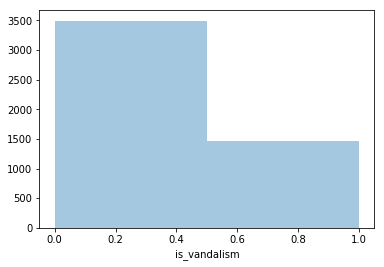

In [135]:
processed_df = widget.result
print('Feature config:', widget.kwargs['features'], ', Features after preprocessing:', len(processed_df.columns))

sns.distplot(processed_df['is_vandalism'].map(lambda x: 1 if x else 0), kde=False,  bins=2)
plt.show()

In [136]:
# X, y split
X = processed_df.drop(['is_vandalism'], axis=1)
y = processed_df['is_vandalism']

In [137]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (3723, 83)
y train (3723,)
X test (1242, 83)
y test (1242,)


---
## Grid search model parameters

In [138]:
# Grid search model params
# 'class_weight': ['balanced', {0:1,1:1}, {0:2,1:1}, {0:4,1:1}, {0:6,1:1}, {0:8,1:1}, {0:10,1:1}, {0:20,1:1}]
parameters = [{
    'n_estimators': [300], 
    'class_weight': ['balanced']
}]

grid_search = GridSearchCV(RandomForestClassifier(),
                           parameters, 
                           scoring=['f1', 'precision', 'recall', 'roc_auc'],
                           refit='f1',
                           cv=10,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

params = grid_search.best_params_
print('Best params', grid_search.best_params_)
print('Best score', grid_search.best_score_)

Best params {'class_weight': 'balanced', 'n_estimators': 300}
Best score 0.6204751977406536


---
## Train: Cross evaluate model using best parameters

In [139]:
# Train scores & predictions
clf = RandomForestClassifier(n_estimators=params['n_estimators'], class_weight=params['class_weight'], n_jobs=-1)
train_scores = cross_validate(clf, X_train, y_train,
                        scoring=['f1', 'precision', 'recall', 'roc_auc', 'accuracy'],
                        cv=10, n_jobs=-1, return_train_score=False)

y_train_predict = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict')
y_train_predict_proba = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')

Cross validation scores


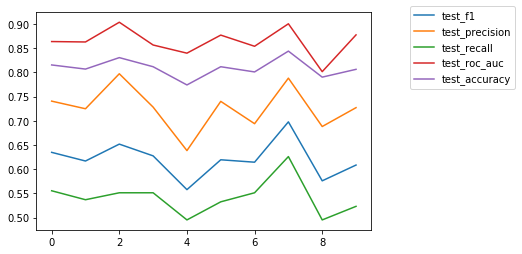

In [140]:
plot_scores(train_scores)

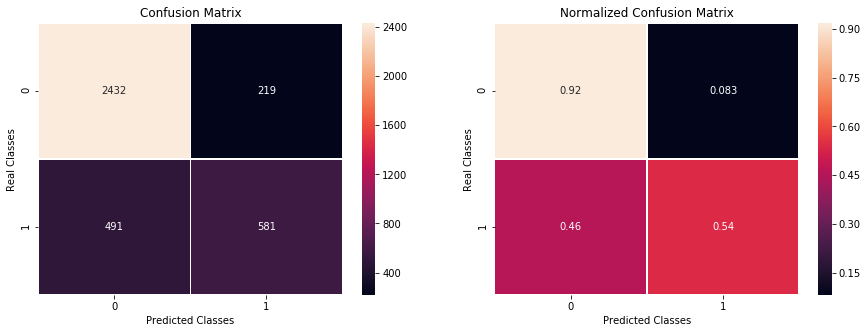

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.83      0.92      0.87      2651
   Vandalism       0.73      0.54      0.62      1072

 avg / total       0.80      0.81      0.80      3723



In [141]:
plot_confusion_matrix(y_train, y_train_predict)

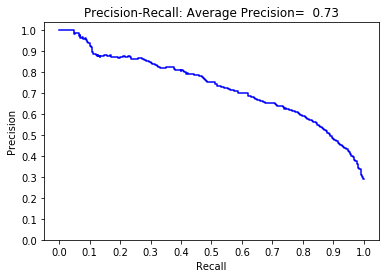

Precision / Recall AUC 0.730836573267857


In [142]:
plot_precision_recall(y_train, y_train_predict_proba[:, 1])

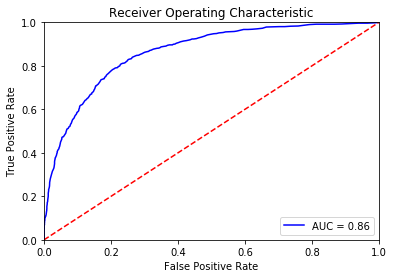

Receiver Operation Characteristic AUC 0.8633803704037339


In [143]:
plot_roc(y_train, y_train_predict_proba[:, 1])

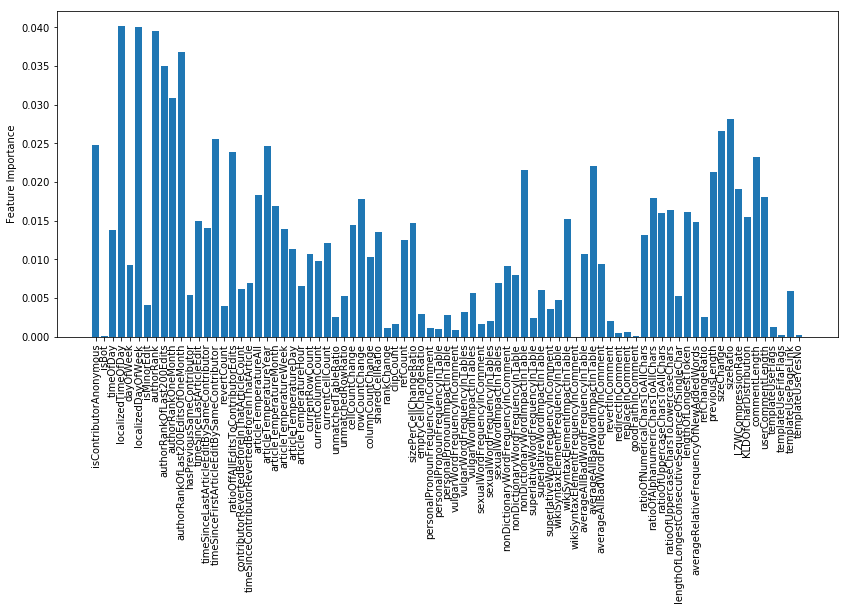

In [144]:
# Feature importance
clf = RandomForestClassifier(n_estimators=params['n_estimators'], class_weight=params['class_weight'], n_jobs=-1)
clf.fit(X_train, y_train)
plot_feature_importance(clf, X_train.columns)

---
## Test: Test model on final test dataset

In [145]:
clf = RandomForestClassifier(n_estimators=params['n_estimators'], class_weight=params['class_weight'], n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [146]:
y_test_predict = clf.predict(X_test)
y_test_predict_proba = clf.predict_proba(X_test)

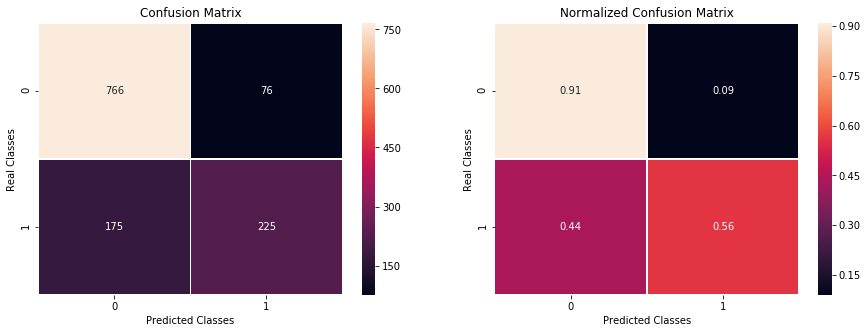

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.81      0.91      0.86       842
   Vandalism       0.75      0.56      0.64       400

 avg / total       0.79      0.80      0.79      1242



In [147]:
plot_confusion_matrix(y_test, y_test_predict)

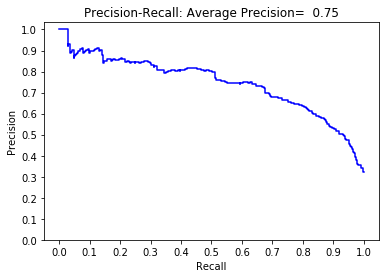

Precision / Recall AUC 0.7457199630368174


In [148]:
plot_precision_recall(y_test, y_test_predict_proba[:, 1])

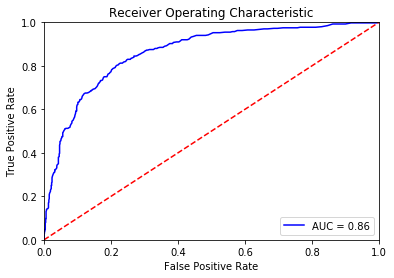

Receiver Operation Characteristic AUC 0.862517814726841


In [149]:
plot_roc(y_test, y_test_predict_proba[:, 1])

In [150]:
# False positives for the test set
fp_test = X_test[(y_test == 0) & (y_test_predict == 1)]
fp_with_labels = fp_test.join(df, rsuffix='_original')
fp_with_labels[['tag_id']].head(10)

,tag_id
revision_id,
10684846,12
21425567,12
46323645,12
47489036,12
65786291,12
65887808,12
67175555,12
73575068,12
83182458,12


In [151]:
# False negatives for the test set
fp_test = X_test[(y_test == 1) & (y_test_predict == 0)]
fp_with_labels = fp_test.join(df, rsuffix='_original')
fp_with_labels[['tag_id']].head(20)

,tag_id
revision_id,
15540587,5
15540587,11
21189768,6
29789136,11
29789136,5
43284976,3
45492728,1
45492728,2
45492728,11


In [152]:
# Inspect revision
@interact(revision_id='', label=X.columns)
def show_revision(revision_id, label):
    if len(revision_id) > 1:
        print(df.loc[int(revision_id)][['tag_id', label]])

interactive(children=(Text(value='', description='revision_id'), Dropdown(description='label', options=('isCon…

In [153]:
# Feature histogramm
@interact(label=X.columns)
def show_feature_per_tag(label):
    sns.jointplot(x='tag_id', y=label, data=df)
    plt.show()
    print('Revisions with highest values')
    print(df.sort_values([label], ascending=[False])[['tag_id', label]].head(10))

interactive(children=(Dropdown(description='label', options=('isContributorAnonymous', 'isBot', 'timeOfDay', '…

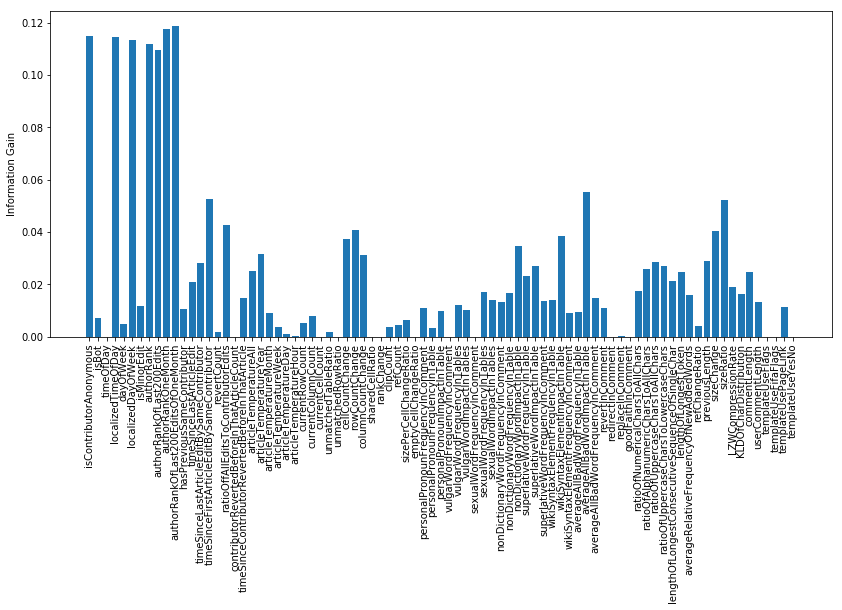

In [154]:
# Information Gain
plot_information_gain(X, y)